# Generative modelling in deep learning

Generative modelling in machine learning can aim at achieving different goals.

The first, obvious one is that a generative model can be used to generate more data, to be used afterwards by another algorithm. While a generative model cannot create more information to solve the issue of having too small datasets, it could be used to solve anonymity questions. Typically, sharing a generative model trained on private data could allow the exploitation of the statistical property of this data without sharing the data itself (which can be protected by privacy matters for example).

Another goal is to use generative modelling to better understand the data at hand. This is based on the hypothesis that a model that successfully learned to generate (and generalize) a dataset should have internally learned some efficient and compressed representation of the information contained in the data. In this case, analysing a posteriori the learned representation may give us insights on the data itself.

The notion of a generative model however needs to be more formally specified, in order to work with. What does it mean for the model to generate data that "looks like" the original dataset? A mathematical formulation of that is necessary, in order to define a training objective that can be used efficiently. Having some expert rate the quality of all generated datapoints one by one is definitely not an option.

Thus, modelling our data and models as probability distributions comes to the rescue. If we consider our data as coming from some underlying probability distribution, that we will name $p_D$, our goal is thus to train our model to represent another probability distribution, which we will name $p_\theta$, that should be some good approximation of $p_D$. Given that we only know $p_D$ through some set of realisations from it (the dataset), we can never hope to learn it exactly.

**Q1: Can you name some metrics that can be used to compare two given distributions $p_D$ and $p_\theta$?**

> We can name two metrics that are commonly used to compare two given distributions : 
- The Kullback-Leibler divergence $$D_{\mathrm{KL}}\left(p_D \| p_\theta\right) = -\int_{\mathcal{Z}} \log \left(\frac{p_\theta(z)}{p_D(z)}\right) p_D(z) \mathrm{d} z$$
- Wasserstein distance, which is somehow the cost of the optimal transport plan between the two distributions $$W\left(p_{D}, p_{\theta}\right)=\inf _{\gamma \in \pi\left(p_{D}, p_{\theta}\right)} \mathbb{E}_{(x, y) \sim \gamma}[\|x-y\|] \text{ , with } \gamma(x,y) \text{ being the joint distribution}$$

Most comparison methods can be separated into two kinds: those that compare the density of the distributions ($p_\theta(x)$ vs $p_D(x)$), and those that compare the values sampled from them. These two kinds of approaches have different behavior and trade-offs.

**Q2: Given that we want to use them as an optimisation objective, what are the caveats to keep in mind about these two kinds?**

> For both types of metrics that will be used as a loss, we need them to :
- conveniently represent the data in order to use the KL divergence : how can we obtain the distribution itself which is a continuous function ? Or how can we get meaningful data to get a good approximation of the distribution ? (GAN)
- consider only tractable operations in order to be able to compute the gradient and perform the backpropagation on the whole network (VAE)

In this work, we will focus on two of the most widely used generative models based on deep neural networks: Generative Adversarial Networks (GANs) and Variational AutoEncoders (VAEs), in order to compare them and understand their strengths and weaknesses.

### Generative Adversarial Networks

GANs structure is based on modelling the distribution $p_\theta$ as a learned deterministic function applied to a standard noise. Sampling from it is thus done as follows: first, some noise is sampled from a standard N-dimensional Gaussian distribution: $\epsilon \sim \mathcal{N}(0;I)$, and then the output is computed as a deterministic function $x = f_\theta(\epsilon)$. The function $f_\theta$ is implemented as a neural network, $\theta$ representing its learned parameters.

**Q3: What is, a priori, the impact of the choice of N, the dimension of the input noise?**

> N is somehow the degrees of freedom to compute new data. With a very low value of N, the model will have much difficulty to produce very various data. With a too high value of N, the model would probably have much difficulty to converge. We think in fact that this is highly related to manifolds. Indeed, when trying to generate new faces for instance (picture of millions of dimensions ie the number of pixels), the object (here the face) lies in fact in a much smaller space which is called a manifold. One could think of the 43 face muscles to represent a face, which is much smaller than the millions of dimensions of the image. Here, the idea is pretty much the same. If N were 43, then we would theoretically be able to associate each dimension to a muscle of which the caracteristics can be drawn from a normal distribution. However, this exact number of dimensions would probably much too low to efficiently enable the model to sample from it and create a convenient face. But a too high value of N would also require much computaton since the number of parameters would be much bigger... Thus, we need to tune this parameter in each case.

By construction, this generator structure only allows sampling the distribution $p_\theta$, and does not allow the computation of the density $p_\theta(x)$ (at least not without strong assumptions on $f_\theta$). Such a model thus needs a comparison method based on samples to be trained.

The smart idea of GANs is to instead use another neural network to model the objective. Another neural network is introduced: a classifier (that we call the discriminator) which is trained to distinguish examples from the dataset from examples generated by $p_\theta$. The reasoning is as follows:

The discriminator $D$ is trained using a classic classifier loss between the two classes defined as the samples generated by either $p_D$ or $p_\theta$. This way $D(x)$ can be interpreted as the probability that $x$ came from the real dataset:

$$ \mathcal{L}_D = \mathbb{E}_{p_D} \left[ -\log D(x) \right] + \mathbb{E}_{p_\theta} \left[ -\log \left(1-D(x)\right) \right] $$

From that, it can be shown that the optimal discriminator is given by $D(x) = \frac{p_D(x)}{p_\theta(x) + p_D(x)}$, and when reached its loss takes a specific value:

$$ \mathcal{L}_D = 2 \left( \log 2 - JSD(p_\theta \| p_D) \right) $$

So, training the generator network to *maximize* the same loss would, assuming the discriminator is always trained to optimality, minimize the Jensen-Shannon Divergence between $p_\theta$ and $p_D$, and thus bring $p_\theta$ closer to $p_D$.

**Q4: Can you anticipate a caveat of using the JSD as a training objective for the generator?**

> Please note that by definition $\operatorname{JSD}(p_\theta \| p_D)=\frac{1}{2} D(p_\theta \| M)+\frac{1}{2} D(p_D \| M) \text{ , where } M = \frac{1}{2} (p_\theta + p_D)$. Unfortunately, this **doesn't have guarantees of continuity and differentiability** which is a major caveat for a loss function...

Having the generator trained to maximize $\mathcal{L}_D$ is equivalent to setting its training loss to $ \mathcal{L}_G = \mathbb{E}_{p_\theta} \log(1-D(x)) $.

**Q5: This loss only gives feedback to the generator on samples it generated, what problem may this cause?**

> The generator may then not learn what is a good sample, but instead only learns to fail the discriminator in his current state. Indeed, we also need to train the discriminator to evolve as well and *adapt* to the generator output. Another idea about the issue of training the generator only on samples it generated is that the generator then never sees real samples and thus may not get the right information to put in the generated data... A way to tackle this issues might be to share the parameters between the generator and the discriminator ?

We will now work on implementing a GAN on a simple toy problem, to get a feeling of its behavior and test our theoretical insights. For this we will use the `pytorch` library.

While a real problem would be generating images for example (each datapoint $x$ would then be a different image), this is a kind of task that easily requires intensive CPU/GPU power, and image datasets are difficult to visualize from a geometric point of view (even small images contains hundreds of pixels, and nobody can visualize points in a 100-dimensional space). So instead we will focus on points in the plane: each datapoint $x$ will actually be a couple of numbers $(x1, x2)$, and our target dataset will be a 2D sinusoidal shape with some noise.

In [1]:
import torch
import math

# Our dataset is mathematically defined, we can generate batches on the fly and enjoy
# an infinite-size dataset
def generate_batch(batchlen):
    """This function generates a batch of length 'batchlen' from the dataset
    """
    t = torch.zeros(batchlen,1).uniform_(-math.pi,math.pi)
    x = t
    y = torch.cos(math.pi*t/4+math.pi/4)**2 + 0.3*torch.cos(2*math.pi*t)
    noise = torch.empty(batchlen, 2).normal_()
    data = torch.cat((x, y), dim=1)
    data += noise * 0.05 * torch.cos(math.pi*t.view(batchlen, 1)/6 + math.pi/2)**2
    return data

Let's plot a large batch, to see what the dataset looks like.

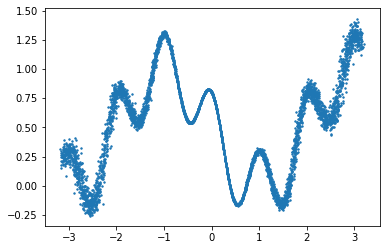

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

batch = generate_batch(5000)

plt.scatter(batch[:,0], batch[:,1], s=2.0)
plt.show()

We now need to define our two neural networks, the generator and the discriminator. The generator will take as input a value $z$ sampled from a Gaussian prior, and output a value $x$ (thus a couple $(x_1,x_2)$). The discriminator takes as input a value $x$, and is a binary classifier.

In [152]:
import torch.nn as nn
import torch.nn.functional as F

# Choose a value for the prior dimension
PRIOR_N = 20

# Define the generator
class Generator(nn.Module):
    def __init__(self, prior=PRIOR_N, n_hidden_layers=0, n_neurons=2, 
                 hidden_activations=torch.relu, output_activation=torch.sigmoid):
        super().__init__()
        self.n_layers = n_hidden_layers
        if type(n_neurons)==int:
            self.n_neurons = [prior] + [n_neurons for _ in range(n_hidden_layers)]
        else:
            assert type(n_neurons)==list
            assert len(n_neurons)==n_hidden_layers
            self.n_neurons = [prior] + n_neurons
        
        for i in range(self.n_layers):
            input_dim = self.n_neurons[i]
            output_dim = self.n_neurons[i+1]
            setattr(self,
                    "layer_{}".format(i+1),
                    nn.Linear(input_dim, output_dim))
        
        self.out = nn.Linear(self.n_neurons[-1], 2)
        
        self.hidden_activations = hidden_activations
        self.output_activation = output_activation
        
    def __call__(self, inputs):
        x = inputs
        for i in range(self.n_layers):
            x = getattr(self, "layer_{}".format(i+1))(x)
            if i < self.n_layers - 1 and self.hidden_activations:
                x = self.hidden_activations(x)
        outputs = self.output_activation(self.out(x))
        return outputs
    
    def generate(self, batchlen):
        inputs = torch.normal(torch.zeros(batchlen, PRIOR_N), 1.0)
        return self.__call__(inputs)
    

# Define the discriminator
class Discriminator(nn.Module):
    def __init__(self, n_hidden_layers=0, n_neurons=2, 
                 hidden_activations=torch.relu, output_activation=torch.sigmoid):
        super().__init__()
        self.n_layers = n_hidden_layers
        if type(n_neurons)==int:
            self.n_neurons = [2] + [n_neurons for _ in range(n_hidden_layers)]
        else:
            assert type(n_neurons)==list
            assert len(n_neurons)==n_hidden_layers
            self.n_neurons = [2] + n_neurons
        
        for i in range(self.n_layers):
            input_dim = self.n_neurons[i]
            output_dim = self.n_neurons[i+1]
            setattr(self,
                    "layer_{}".format(i+1),
                    nn.Linear(input_dim, output_dim))
        
        self.out = nn.Linear(self.n_neurons[-1], 1)
        
        self.hidden_activations = hidden_activations
        self.output_activation = output_activation
        
    def __call__(self, inputs):
        x = inputs
        for i in range(self.n_layers):
            x = getattr(self, "layer_{}".format(i+1))(x)
            if i < self.n_layers - 1 and self.hidden_activations:
                x = self.hidden_activations(x)
                    
        outputs = self.output_activation(self.out(x))
        return outputs

With these classes in shape, now is only needed the training loop. To stick with the mathematical GAN framework, we should train the discriminator until convergence between each training step of the generator. This is not practical for two reasons: first it takes a lot of time, and second if the discriminator is too good, it will generate vanishing gradients to the generator (as seen in **Q4**).

We will thus train the discriminator a fixed number of times between each training iteration of the generator.

In [169]:
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

# Choose a value for the prior dimension
PRIOR_N = 1000
# Number of times to train the discriminator between two generator steps
TRAIN_RATIO = 6
# Total number of training iterations for the generator
N_ITER = 20001
# Batch size to use
BATCHLEN = 2**6


def predict(model, x):
    model.eval() # set the model to test mode
    with torch.no_grad():
        y_pre = model(torch.from_numpy(x).type(torch.float32)).view(-1)
    return y_pre


def plot_predictions(generator, discriminator, nb_steps):
    plt.figure(figsize=(16, 4))
    plt.suptitle('Visualization after {} steps'.format(nb_steps))

    # plot the result
    real_batch = generate_batch(1024)
    fake_batch = generator.generate(1024).detach()
    plt.subplot(121)
    plt.scatter(real_batch[:,0], real_batch[:,1], s=2.0, label='real data')
    plt.scatter(fake_batch[:,0], fake_batch[:,1], s=2.0, label='fake data')
    plt.legend()
    plt.title('Ground Truth')

    ### Plot our results with decision boundaries
    plt.subplot(122)
    plt.scatter(real_batch[:,0], real_batch[:,1], s=2.0, label='real data')
    plt.scatter(fake_batch[:,0], fake_batch[:,1], s=2.0, label='fake data')
    plt.legend()
    plt.title("Decision Boundary - Discriminator")

    # Set min and max values and give it some padding
    x_min, x_max = real_batch[:, 0].min() - 0.2, real_batch[:, 0].max() + 0.2
    y_min, y_max = real_batch[:, 1].min() - 0.1, real_batch[:, 1].max() + 0.1
    h = 0.01

    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Predict the function value for the whole grid
    predicter = lambda x: predict(discriminator, x)
    Z = predicter(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.5)

    plt.show()


def trainer(ratio=TRAIN_RATIO, epochs=N_ITER, plot=True, n_layers_gen=3, n_neurons_gen=7, 
                                                         n_layers_disc=3, n_neurons_disc=7):

    generator = Generator(n_hidden_layers=n_layers_gen, n_neurons=n_neurons_gen, prior=PRIOR_N,
                          hidden_activations=None)
    optim_gen = torch.optim.Adam(generator.parameters(), lr=0.001, betas=(0.5,0.9))
    discriminator = Discriminator(n_hidden_layers=n_layers_disc, n_neurons=n_neurons_disc)
    optim_disc = torch.optim.Adam(discriminator.parameters(), lr=0.0001, betas=(0.5,0.9))
    
    memory_disc_loss, memory_disc_grads = [], []
    memory_gen_loss, memory_gen_grads = [], []
    for i in range(epochs):
        #for param in generator.parameters():
        #    print(param.grad)
        #    break
        # train the discriminator
        for _ in range(ratio):
            discriminator.zero_grad()
            real_batch, real_labels = generate_batch(BATCHLEN), torch.ones((BATCHLEN,), dtype=torch.long)
            fake_batch, fake_labels = generator.generate(BATCHLEN), torch.zeros((BATCHLEN,), dtype=torch.long)
            disc_dataset = TensorDataset(torch.cat((real_batch, fake_batch)),
                                         torch.cat((real_labels, fake_labels)))
            loader = DataLoader(disc_dataset, batch_size=2*BATCHLEN, shuffle=True)
            disc_loss = 0.0
            for (data, targets) in loader: # only one batch anyway
                prediction = discriminator(data).flatten()
                if torch.isnan(prediction).any():
                    print('Nan detected at global epoch {}, disc epoch {} with prediction = {}'.format(
                                                        i,             _,               prediction))
                    print('Memory of losses : ', memory_disc_loss)
                    print('Memory of grads : ', memory_disc_grads)
                    break
                #print('DISC predictions {} : '.format(i), prediction)
                disc_loss += - torch.sum(torch.log(prediction) * targets + torch.log(1-prediction) * (1-targets))
                memory_disc_loss.append(disc_loss)
                memory_disc_loss = memory_disc_loss[-100:] if len(memory_disc_loss)>100 else memory_disc_loss
                #print('DISC {} : '.format(i), disc_loss)
            disc_loss.backward()
            loc_grads = []
            for param in discriminator.parameters():
                loc_grads.append(param.grad)
            memory_disc_grads.append(loc_grads)
            memory_disc_grads = memory_disc_grads[-100:] if len(memory_disc_grads)>100 else memory_disc_grads
            optim_disc.step()
        # train the generator
        generator.zero_grad()
        fake_batch = generator.generate(BATCHLEN)
        prediction = discriminator(fake_batch)
        if torch.isnan(prediction).any():
            print('Nan detected at global epoch {}, after generating {} and disc prediction = {}'.format(
                                                i,              fake_batch,              prediction))
            print('Memory of losses : ', memory_disc_loss)
            print('Memory of grads : ', memory_disc_grads)
            break
        gen_loss = - torch.sum(torch.log(prediction))
        #print('DISC {} : '.format(i), gen_loss)
        gen_loss.backward()
        memory_gen_loss.append(gen_loss)
        memory_gen_loss = memory_gen_loss[-100:] if len(memory_gen_loss)>100 else memory_gen_loss
        loc_grads = []
        for param in generator.parameters():
            loc_grads.append(param.grad)
        memory_gen_grads.append(loc_grads)
        memory_gen_grads = memory_gen_grads[-100:] if len(memory_gen_grads)>100 else memory_gen_grads
        optim_gen.step()
        if (plot and i%1000 == 0) or ((not plot) and i+1 == epochs):
            print('step {}: discriminator: {:.3e}, generator: {:.3e}'.format(i, float(disc_loss),
                                                                             float(gen_loss)))
            
            plot_predictions(generator, discriminator, nb_steps=i)

step 0: discriminator: 8.778e+01, generator: 5.001e+01


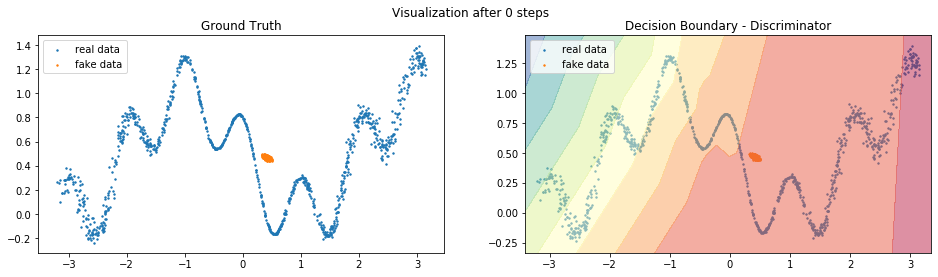

Nan detected at global epoch 542, disc epoch 2 with prediction = tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan], grad_fn=<ViewBackward>)
Memory of losses :  [tensor(46.3512, grad_fn=<AddBackward0>), tensor(50.8799, grad_fn=<AddBackward0>), tensor(46.8713, grad_fn=<AddBackward0>), tensor(48.5443, grad_fn=<AddBackward0>), tensor(50.0409, grad_fn=<AddBackward0

AttributeError: 'float' object has no attribute 'backward'

In [170]:
trainer()

Complete the previous code and train your model.

Depending on your choice of parameters, the training may not go well at all, with the generator completely collapsing quickly at the beginning of the training. It has been observed by the litterature that the generator's loss $\mathcal{L}_G = \mathbb{E}_{p_\theta} \log(1-D(x))$ is often to blame.

**Q6: Why could we anticipate that this loss could cause this?**

> If the discriminator is very bad at first, then the gradients for the generator to fool the discriminator are too weak since it is already fooled... However, if the discriminator is very good at first, then with the sigmoid function and its shrinking weak extrema gradients, $\nabla\mathcal{L}_G \sim - \frac{D'(x)}{1-D(x)}$, in which the derivative is close to zero and the denominator is close to 1. Thus the gradients are too small and the model doesn't update. Thus we get the sense that the choice of the ratio is critical in order to make the model converge, which makes the whole approach very hard to tune.

This issue is solved by replacing the generator loss by an alternative loss: $\mathcal{L}_G = \mathbb{E}_{p_\theta} [ -\log D(x) ]$.

**Q7: Inspect the impact of these different factors:**

- depth / width of the generator network
- depth / width of the discriminator network
- impact of `TRAIN_RATIO`

In [ ]:
#-------------------------------------------------------------------
# Impact of the depth/width of the generator
layers = [1,2,3,5,10]
neurons = [3,5,7,10,50,100]
for lay in layers:
    for neu in neurons:
        trainer(n_layers_gen=lay, n_neurons_gen=neu)

#-------------------------------------------------------------------
# Impact of the depth/width of the discriminator
layers = [1,2,3,5,10]
neurons = [3,5,7,10,50,100]
for lay in layers:
    for neu in neurons:
        trainer(n_layers_disc=lay, n_neurons_disc=neu)

#-------------------------------------------------------------------
# Impact of the depth/width of the generator
ratios = [1,2,3,5,10]
for rat in ratios:
    trainer(ratio=rat)

> **ADD COMMENTS**

For further readings on GANs, you can see the following papers:

- Generative Adversarial Networks *(Goodfellow et al.)*: [arXiv:1406.2661](https://arxiv.org/abs/1406.2661)
- Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks *(Radford et al.)*: [arXiv:1511.06434](https://arxiv.org/abs/1511.06434)

### Variational AutoEncoders

Another well-known approach to generative modelling is embodied by Variational AutoEncoders (VAEs). While the generative model itself and the procedure to sample it is similar to GANs, the way it is trained is not.

The main goal of VAEs is to optimize the likelihood of the real data according to the generative model. In other words, maximize $\mathbb{E}_{p_D} \log p_\theta(x)$, which is equivalent to minimizing $D_{KL}(p_D \| p_\theta)$.

**Q8: Prove this equivalence.**

\begin{align}
D_{\mathrm{KL}}\left(p_D \| p_\theta\right) &= -\int_{\mathcal{Z}} \log \left(\frac{p_\theta(z)}{p_D(z)}\right) p_D(z) \mathrm{d} z \\
& = - \mathbb{E}_{p_D} \log \frac{p_\theta(x)}{p_D(x)} \\
& = - \mathbb{E}_{p_D} (\log p_\theta(x)) + \mathbb{E}_{p_D} (\log p_D(x))
\end{align}

However, the classes of distributions for which $\log p_\theta(x)$ can be analytically computed and optimized is very restricted, and not suitable for real world problems. The main idea of the VAE is thus to introduce a latent variable $z$ and decompose the distribution as: $p_\theta(x, z) = p_\theta(x | z) p(z)$. Here $p(z)$ is some fixed prior and $p_\theta(x | z)$ is a simple distribution whose parameters are the output of a neural network.

For example, you could have $p(z)$ be a standard $\mathcal{N}(0;1)$ and $p_\theta(x | z)$ be defined as a gaussian $\mathcal{N}(\mu_\theta(z); \sigma_\theta(z))$ where $\mu_\theta(z)$ and $\sigma_\theta(z)$ are created by the neural network you will train. In this case, the resulting distribution $p_\theta(x) = \int_z p_\theta(x|z)p(z)dz$ is an infinite mixture of Gaussians, which is a much more expressive class of distributions.

Now, this cannot stop here, as we are not able to analitically compute the density $p_\theta(x)$. The second main idea of the VAE is to introduce another, auxilliary distribution: $q_\phi(z | x)$, which will be modelled by a neural network similarly to $p_\theta(x | z)$. Introducing it allows us to create a lower bound for $\log p_\theta(x)$:

$$\log p_\theta(x) = \mathbb{E}_{z \sim q_\phi} \log p_\theta(x) = \mathbb{E}_{z \sim q_\phi} \left[ \log p_\theta(x) \frac {q_\phi(z|x)}{q_\phi(z|x)} \right]$$

Following Bayes theorem, $p_\theta(x) p_\theta(z|x) = p_\theta(x, z) = p_\theta(x|z) p(z)$, so we get:

$$\log p_\theta(x) = \mathbb{E}_{z \sim q_\phi} \left[ \log \frac{p_\theta(x|z) p(z)}{p_\theta(z|x)} \frac {q_\phi(z|x)}{q_\phi(z|x)} \right]$$

Re-organizing the terms:

$$\log p_\theta(x) = \mathbb{E}_{z \sim q_\phi} \log \frac{q_\phi(z|x)}{p_\theta(z|x)} + \mathbb{E}_{z \sim q_\phi} \log \frac{p(z)}{q_\phi(z|x)} + \mathbb{E}_{z \sim q_\phi} \log p_\theta(x | z)$$

This can be re-expressed like so:

$$\log p_\theta(x) = D_{KL}(q_\phi(z | x) \| p_\theta(z | x)) - D_{KL}(q_\phi(z | x) \| p(z)) + \mathbb{E}_{z \sim q_\phi} \log p_\theta(x|z)$$

The 3 terms of this equality can be interpreted like so:

- the first term measures how much $q_\phi(z | x)$ is similar to $p_\theta(z | x)$, or in other words is a good inverse of $p_\theta(x | z)$
- the second term measures how similar $q_\phi(z|x)$ is from the latent prior $p(z)$
- the third term is linked to how likely $p_\theta$ is to yield the given $x$ when $z$ is sampled from $q_\phi(z | x)$ rather than $p(z)$

It is interesting to note that the first term, being a KL-divergence is always positive. As such the combination of the last two terms form a lower bound of $\log p_\theta(x)$ which *can* be computed and used as a training objective. This bound is called the *Evidence Lower-Bound (ELBO)*. Simply flipping its sign can make it into a loss that can be minimized by gradient descent:

$$ \mathcal{L}_{ELBO} = D_{KL}(q_\phi(z | x) \| p(z)) + \mathbb{E}_{z \sim q_\phi} [ - \log p_\theta(x|z) ]$$

From this formulation comes the parallel with auto-encoders that give the VAE its name: $q_\phi(z | x)$ can be seen as a *probabilistic encoder* from the data $x$ to the latent space $z$, and $p_\theta(x | z)$ can be seen as a *probabilistic decoder* from the latent space $z$ to the data $x$. In this case the second term of $\mathcal{L}_{ELBO}$ is the loss measuring the reconstruction quality of the auto-encoder, and the first term can be seens as a regularization of the latent space.

**Q9: We can see that $p(z)$ is never sampled during the training process, how can that be a problem?**

> Since we never sample p(z), we don't optimize exactly the log likelihood and thus don't get a perfect estimator, but instead, we try to optimize a lower bound of it. The other issue is that we may assign high probability to points in the dataset but we could also assign high probability to other points, which can yield noisy results.

A typical choice to represent $q_\phi(z | x)$ is to use a diagonal Gaussian distribution $\mathcal{N}(\mu_\phi(x); Diag(\sigma_\phi^2(x)))$, which makes the KL-divergence term of $\mathcal{L}_{ELBO}$ analytically computable.

**Q10: Assuming $p(z)$ is a $\mathcal{N}(0; Id)$ gaussian, what is the value of $D_{KL}(q_\phi(z | x) \| p(z))$?**

Considering n the dimension of the space, 
\begin{align}
D_{KL}\left(P_{1} \| P_{2}\right) &=\mathrm{E}_{P_{1}}\left[\log P_{1}-\log P_{2}\right] \\ 
&=\frac{1}{2} \mathrm{E}_{P_{1}}\left[-\log \operatorname{det} \Sigma_{1}-\left(x-\mu_{1}\right)^{T} \Sigma_{1}^{-1}\left(x-\mu_{1}\right)+\log \operatorname{det} \Sigma_{2}+\left(x-\mu_{2}\right)^{T} \Sigma_{2}^{-1}\left(x-\mu_{2}\right)\right] \\ 
&=\frac{1}{2} \log \left(\frac{\operatorname{det} \Sigma_{2}}{\operatorname{det} \Sigma_{1}}\right)+\frac{1}{2} \mathrm{E}_{P_{1}}\left[-\left(x-\mu_{1}\right)^{T} \Sigma_{1}^{-1}\left(x-\mu_{1}\right)+\left(x-\mu_{2}\right)^{T} \Sigma_{2}^{-1}\left(x-\mu_{2}\right)\right] \\ 
&=\frac{1}{2} \log \left(\frac{\operatorname{det} \Sigma_{2}}{\operatorname{det} \Sigma_{1}}\right)+\frac{1}{2} \mathrm{E}_{P_{1}}\left[-\operatorname{tr}\left(\Sigma_{1}^{-1}\left(x-\mu_{1}\right)\left(x-\mu_{1}\right)^{T}\right)+\operatorname{tr}\left(\Sigma_{2}^{-1}\left(x-\mu_{2}\right)\left(x-\mu_{2}\right)^{T}\right)\right] \\ 
&=\frac{1}{2} \log \left(\frac{\operatorname{det} \Sigma_{2}}{\operatorname{det} \Sigma_{1}}\right)+\frac{1}{2} \mathrm{E}_{P_{1}}\left[-\operatorname{tr}\left(\Sigma_{1}^{-1} \Sigma_{1}\right)+\operatorname{tr}\left(\Sigma_{2}^{-1}\left(x x^{T}-2 x \mu_{2}^{T}+\mu_{2} \mu_{2}^{T}\right)\right)\right] \\ 
&=\frac{1}{2} \log \left(\frac{\operatorname{det} \Sigma_{2}}{\operatorname{det} \Sigma_{1}}\right)-\frac{1}{2} n+\frac{1}{2} \operatorname{tr}\left(\Sigma_{2}^{-1}\left(\Sigma_{1}+\mu_{1} \mu_{1}^{T}-2 \mu_{2} \mu_{1}^{T}+\mu_{2} \mu_{2}^{T}\right)\right) \\ 
&=\frac{1}{2}\left(\log \frac{\operatorname{det} \Sigma_{2}}{\operatorname{det} \Sigma_{1}}-n+\operatorname{tr}\left(\Sigma_{2}^{-1} \Sigma_{1}\right)+\operatorname{tr}\left(\mu_{1}^{T} \Sigma_{2}^{-1} \mu_{1}-2 \mu_{1}^{T} \Sigma_{2}^{-1} \mu_{2}+\mu_{2}^{T} \Sigma_{2}^{-1} \mu_{2}\right)\right) \\ 
&=\frac{1}{2}\left(\log \frac{\operatorname{det} \Sigma_{2}}{\operatorname{det} \Sigma_{1}}-n+\operatorname{tr}\left(\Sigma_{2}^{-1} \Sigma_{1}\right)+\left(\mu_{2}-\mu_{1}\right)^{T} \Sigma_{2}^{-1}\left(\mu_{2}-\mu_{1}\right)\right)
\end{align}

Which for $P_{1} = \mathcal{N}(\mu_\phi(x); Diag(\sigma_\phi^2(x)))$ and $P_{2} = \mathcal{N}(0; Id)$ gives :
$$D_{KL}(q_\phi(z | x) \| p(z)) = \frac{1}{2}\left(\sum (\sigma_\phi^2 - \log (\sigma_\phi^2)) + (\mu_\phi(x))^{\top}(\mu_\phi(x))-n\right)$$

We will also model $p_\theta(x | z)$ as a diagonal Gaussian $\mathcal{N}(\mu_\theta(z); Diag(\sigma_\theta^2(z)))$.


**Note:** For the following, be careful about the difference between $\mu_\phi, \sigma_\phi$ which define the Gaussian distribution of the *encoder* $q_\phi$ and $\mu_\theta, \sigma_\theta$ which define the Gaussian distribution of the *decoder* $p_\theta$.

**Q11: What is the expression of $-\log p_\theta(x | z)$ for given $x$ and $z$?**

> Since $$p_\theta(x | z) \sim \mathcal{N}(\mu_\theta(z); Diag(\sigma_\theta^2(z)))$$ one has $$p_\theta(x | z)=\frac{1}{(2 \pi)^{n / 2} \operatorname{det}(Diag(\sigma_\theta^2(z)))^{1 / 2}} \exp \left(-\frac{1}{2}(x-\mu_\theta(z))^{T} Diag(\sigma_\theta^2(z))^{-1}(x-\mu_\theta(z))\right)$$ and thus, $$-\log p_\theta(x | z) = \frac{n}{2} \log(2 \pi) + \frac{1}{2} \sum\log(\sigma_\theta^2(z)) + \left(\frac{1}{2}(x-\mu_\theta(z))^{T} Diag(\sigma_\theta^2(z))^{-1}(x-\mu_\theta(z))\right)$$

We will build and train a VAE using the same dataset as previously, in order to compare its behavior to GANs. For numerical stability, we will interpret the output of the encoder and decoder networks as $(\mu, \log\sigma^2)$, rather than $(\mu, \sigma)$.

In [ ]:
# Choose a value for the latent dimension
LATENT_N = 10

# Define the generator
class Encoder(nn.Module):
    def __init__(self, embed_size=LATENT_N, n_hidden_layers=0, n_neurons=2, 
                 hidden_activations=torch.relu, output_activation=torch.sigmoid):
        super().__init__()
        self.n_layers = n_hidden_layers
        if type(n_neurons)==int:
            self.n_neurons = [2] + [n_neurons for _ in range(n_hidden_layers)]
        else:
            assert type(n_neurons)==list
            assert len(n_neurons)==n_hidden_layers
            self.n_neurons = [2] + n_neurons
        
        for i in range(self.n_layers):
            input_dim = self.n_neurons[i]
            output_dim = self.n_neurons[i+1]
            setattr(self,
                    "layer_{}".format(i+1),
                    nn.Linear(input_dim, output_dim))
        
        self.mu1 = nn.Linear(self.n_neurons[-1], 5)
        self.mu2 = nn.Linear(5, embed_size)
        self.logvar1 = nn.Linear(self.n_neurons[-1], 5)
        self.logvar2 = nn.Linear(5, 10)
        self.logvar3 = nn.Linear(10, 5)
        self.logvar4 = nn.Linear(5, embed_size)
        
        self.hidden_activations = hidden_activations
        
    # encode a datapoint. This should return a couple of tensors (mu, logvar) representing
    # the parameters of the Gaussian q_\phi(z | x)
    def __call__(self, inputs):
        x = inputs
        for i in range(self.n_layers):
            x = getattr(self, "layer_{}".format(i+1))(x)
            if i < self.n_layers - 1:
                x = self.hidden_activations(x)
                
        mu = self.hidden_activations(self.mu1(x))
        mu = self.mu2(mu)
        logvar = self.hidden_activations(self.logvar1(x))
        logvar = self.hidden_activations(self.logvar2(x))
        logvar = self.hidden_activations(self.logvar3(x))
        logvar = self.logvar4(x)
        return (mu, logvar)
    

# Define the discriminator
class Decoder(nn.Module):
    def __init__(self, embed_size=LATENT_N, n_hidden_layers=0, n_neurons=2, 
                 hidden_activations=torch.relu, output_activation=torch.sigmoid):
        super().__init__()
        self.n_layers = n_hidden_layers
        self.embed_size = embed_size
        if type(n_neurons)==int:
            self.n_neurons = [embed_size] + [n_neurons for _ in range(n_hidden_layers)]
        else:
            assert type(n_neurons)==list
            assert len(n_neurons)==n_hidden_layers
            self.n_neurons = [embed_size] + n_neurons
        
        for i in range(self.n_layers):
            input_dim = self.n_neurons[i]
            output_dim = self.n_neurons[i+1]
            setattr(self,
                    "layer_{}".format(i+1),
                    nn.Linear(input_dim, output_dim))
        
        self.mu1 = nn.Linear(self.n_neurons[-1], 5)
        self.mu2 = nn.Linear(5, 2)
        self.logvar1 = nn.Linear(self.n_neurons[-1], 5)
        self.logvar2 = nn.Linear(5, 10)
        self.logvar3 = nn.Linear(10, 5)
        self.logvar4 = nn.Linear(5, 2)
        
        self.hidden_activations = hidden_activations
        
    # encode a datapoint. This should return a couple of tensors (mu, logvar) representing
    # the parameters of the Gaussian p_\theta(x | z)
    def __call__(self, inputs, mu_hard=None):
        x = inputs
        for i in range(self.n_layers):
            x = getattr(self, "layer_{}".format(i+1))(x)
            if i < self.n_layers - 1:
                x = self.hidden_activations(x)
                
        if not mu_hard:
            mu = self.hidden_activations(self.mu1(x))
            mu = self.mu2(mu)
        else:
            mu = mu_hard
            
        logvar = self.hidden_activations(self.logvar1(x))
        logvar = self.hidden_activations(self.logvar2(x))
        logvar = self.hidden_activations(self.logvar3(x))
        logvar = self.logvar4(x)
        return (mu, logvar)

    def generate(self, batchlen):
        z = torch.normal(torch.zeros(batchlen, self.embed_size), 1.0)
        (mu, logvar) = self.__call__(z)
        return torch.normal(mu, torch.exp(0.5*logvar))

From this, the parameters of both networks are trained conjointly using the same loss $\mathcal{L}_{ELBO}$. Pytorch allows us to sample the Gaussian distribution using `torch.normal(mu, sigma)`, but it is not differentiable wrt to its inputs.

**Q12: How can you sample a distribution $\mathcal{N}(\mu, \sigma)$ is a way that is differentiable w.r.t. both $\mu$ and $\sigma$?**

> We use the reparametrization trick : sample $\epsilon \sim \mathcal{N}(0, I)$ outside of the system keeping track of the gradients and compute $z = \mu + \sqrt{\sigma} * \epsilon$. We thereby get what we want and we don't break the chain rule for propagating the gradients by using a non-differentiable sampling function.

In [ ]:
# Total number of training iterations for the VAE
N_ITER = 40001
# Batch size to use
BATCHLEN = 128

def trainer(ratio=TRAIN_RATIO, epochs=N_ITER, n_layers_gen=3, n_neurons_gen=7, 
                                              n_layers_disc=3, n_neurons_disc=7):

    encoder = Encoder()
    optim_enc = torch.optim.Adam(encoder.parameters(), lr=0.001, betas=(0.5,0.9))
    decoder = Decoder()
    optim_dec = torch.optim.Adam(decoder.parameters(), lr=0.001, betas=(0.5,0.9))
    criterion = nn.MSELoss()

    for i in range(N_ITER):
        encoder.zero_grad()
        decoder.zero_grad()

        x = generate_batch(BATCHLEN)

        enc_mu, enc_logvar = encoder(x)
        loss_kl = 0.5*(torch.sum(torch.exp(enc_logvar) - enc_logvar) + torch.dot(enc_mu.view(-1), 
                                                                                 enc_mu.view(-1)))

        dec_mu, dec_logvar = decoder(z)
        eps = torch.normal(torch.zeros(BATCHLEN, 2), 1.0)
        z = dec_mu + eps * torch.exp(dec_logvar / 4)
        loss_rec = criterion(z,x)

        (loss_kl + loss_rec).backward()
        optim_enc.step()
        optim_dec.step()
        if i%1000 == 0:
            print('step {}: KL: {:.3e}, rec: {:.3e}'.format(i, float(loss_kl), float(loss_rec)))
            # plot the result
            real_batch = generate_batch(1024)
            rec_batch = torch.normal(dec_mu, torch.exp(0.5*dec_logvar)).detach()
            fake_batch = decoder.generate(1024).detach()
            plt.scatter(real_batch[:,0], real_batch[:,1], s=2.0, label='real data')
            plt.scatter(rec_batch[:,0], rec_batch[:,1], s=2.0, label='rec data')
            plt.scatter(fake_batch[:,0], fake_batch[:,1], s=2.0, label='fake data')
            plt.show()

**Q13: Try hardcoding $\sigma_\theta(z)$ to some small value (like 0.01) rather than allowing the decoder to learn it. What does it change?**

> (Write your answer here)

**Q14: How do the power of encoder and decoder affect the overall training of the VAE?**

> (Write your answer here)

**Q15: As a conclusion, how would you compare the advantages and shortcomings of GANs and VAEs?**

> (Write your answer here)